![qiskit_header.png](../../../../images/qiskit_header.png)

# _*Qiskit Finance: qGAN Option Pricing*_ 

The latest version of this notebook is available on https://github.com/Qiskit/qiskit-iqx-tutorials.

***
### Contributors
Christa Zoufal<sup>[1,2]</sup>, Stefan Woerner<sup>[1]</sup>
### Affiliation
- <sup>[1]</sup>IBMQ
- <sup>[2]</sup>ETH Zurich

### Introduction
In this notebook, we discuss how a Quantum Machine Learning Algorithm, namely a quantum Generative Adversarial Network (qGAN), can facilitate the pricing of a European call option. More specifically, a qGAN can be trained such that a quantum circuit models the spot price of an asset underlying a European call option. The resulting model can then be integrated into a Quantum Amplitude Estimation based algorithm to evaluate the expected payoff - see [European Call Option Pricing](../simulation/european_call_option_pricing.ipynb). <br/>
For further details on learning and loading random distributions by training a qGAN please refer to <a href="https://arxiv.org/abs/1904.00043">Quantum Generative Adversarial Networks for Learning and Loading Random Distributions. Zoufal, Lucchi, Woerner. 2019.</a>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit.circuit import ParameterVector
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.finance.components.uncertainty_problems import EuropeanCallExpectedValue
from qiskit.aqua.components.uncertainty_models import UnivariateVariationalDistribution, NormalDistribution
from qiskit.aqua.components.variational_forms import RY
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.aqua.components.initial_states import Custom

from qiskit.aqua import aqua_globals, QuantumInstance

from qiskit import BasicAer

### Uncertainty Model

The Black-Scholes model assumes that the spot price at maturity $S_T$ for a European call option is log-normally distributed. Thus, we can train a qGAN on samples from a log-normal distribution and use the result as an uncertainty model underlying the option. A notebook that explains the implementation of a qGAN to learn and load a random distribution is presented in [qGANs for Loading Random Distributions](../../aqua/machine_learning/qgans_for_loading_random_distributions.ipynb). <br/>
In the following, we construct a quantum circuit that loads the uncertainty model. The circuit output reads 

$$ \big| g_{\theta}\rangle = \sum_{j=0}^{2^n-1}\sqrt{p_{\theta}^{j}} \big| j \rangle , $$

where the probabilities $p_{\theta}^{j}$, for $j\in \left\{0, \ldots, {2^n-1} \right\}$, represent a model of the target distribution.

In [2]:
# Set upper and lower data values
bounds = np.array([0.,7.])
# Set number of qubits used in the uncertainty model
num_qubits = [3]

# Set entangler map
entangler_map = []
for i in range(sum(num_qubits)):
    entangler_map.append([i, int(np.mod(i+1, sum(num_qubits)))])

# Load the trained circuit parameters
g_params = [0.29399714, 0.38853322, 0.9557694,  0.07245791, 6.02626428, 0.13537225]
# Set an initial state for the generator circuit
init_dist = NormalDistribution(int(sum(num_qubits)), mu=1., sigma=1., low=bounds[0], high=bounds[1])
init_distribution = np.sqrt(init_dist.probabilities)
init_distribution = Custom(num_qubits=sum(num_qubits), state_vector=init_distribution)

var_form = RY(int(np.sum(num_qubits)), depth=1, initial_state=init_distribution,
              entangler_map=entangler_map, entanglement_gate='cz')
theta = ParameterVector('θ', var_form.num_parameters)
var_form = var_form.construct_circuit(theta)
# Set generator circuit
g_circuit = UnivariateVariationalDistribution(int(sum(num_qubits)), var_form, g_params,
                                              low=bounds[0], high=bounds[1])
g_circuit._var_form_params = theta
# construct circuit factory for uncertainty model
uncertainty_model = g_circuit


/Users/manoel/anaconda3/envs/QiskitenvProd/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.


### Evaluate Expected Payoff
Now, the trained uncertainty model can be used to evaluate the expectation value of the option's payoff function with Quantum Amplitude Estimation.

In [3]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 2

# set the approximation scaling for the payoff function
c_approx = 0.25

# construct circuit factory for payoff function
european_call = EuropeanCallExpectedValue(
    uncertainty_model,
    strike_price=strike_price,
    c_approx=c_approx
)

### Plot the probability distribution
Next, we plot the trained probability distribution and, for reasons of comparison, also the target probability distribution.

/Users/manoel/anaconda3/envs/QiskitenvProd/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The qiskit.aqua.components.variational_forms.RY object is deprecated as of 0.7.0 and will be removed no sooner than 3 months after the release. You should use qiskit.circuit.library.RealAmplitudes (uses CX entangling) or qiskit.circuit.library.TwoLocal instead.
  


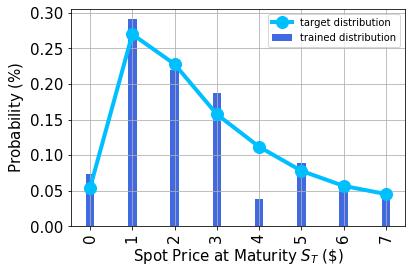

In [4]:
#trained probability distribution
init_distribution = np.sqrt(init_dist.probabilities)
init_distribution = Custom(num_qubits=sum(num_qubits), state_vector=init_distribution)

var_form = RY(int(np.sum(num_qubits)), depth=1, initial_state=init_distribution,
              entangler_map=entangler_map, entanglement_gate='cz')
theta = ParameterVector('θ', var_form.num_parameters)
var_form = var_form.construct_circuit(theta)
g_circuit = UnivariateVariationalDistribution(int(sum(num_qubits)), var_form, g_params, low=bounds[0], high=bounds[1])
g_circuit._var_form_params = theta
uncertainty_model = g_circuit
uncertainty_model.set_probabilities(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
x = uncertainty_model.values
y = uncertainty_model.probabilities
#target probability distribution
N = 100000
log_normal = np.random.lognormal(mean=1, sigma=1, size=N)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= 7]

log_normal_samples = []
for i in range(8):
    log_normal_samples += [np.sum(log_normal==i)]
log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))


plt.bar(x, y, width=0.2, label='trained distribution', color='royalblue')
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.plot(log_normal_samples,'-o', color ='deepskyblue', label='target distribution', linewidth=4, markersize=12)
plt.legend(loc='best')
plt.show()

### Evaluate Expected Payoff
Now, the trained uncertainty model can be used to evaluate the expectation value of the option's payoff function analytically and with Quantum Amplitude Estimation.

Analytically calculated expected payoff w.r.t. the target distribution:  1.0665767779630746
Analytically calculated expected payoff w.r.t. the trained distribution:  0.980530833264945
Expected payoff calculated with Quantum Amplitude Estimation: 	1.2580
Probability: 	0.8785


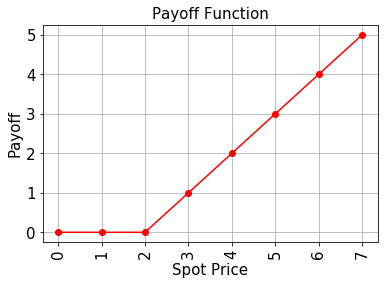

In [5]:
payoff = np.array([0,0,0,1,2,3,4,5])
ep = np.dot(log_normal_samples, payoff)
print("Analytically calculated expected payoff w.r.t. the target distribution: ", ep)
ep_trained = np.dot(y, payoff)
print("Analytically calculated expected payoff w.r.t. the trained distribution: ", ep_trained)

# set number of evaluation qubits (samples)
m = 5

# construct amplitude estimation 
ae = AmplitudeEstimation(m, european_call)
# result = ae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'), shots=100)
result = ae.run(quantum_instance=BasicAer.get_backend('statevector_simulator'))
print('Expected payoff calculated with Quantum Amplitude Estimation: \t%.4f' % result['estimation'])
print('Probability: \t%.4f' % result['max_probability'])

# plot exact payoff function (evaluated on the grid of the trained uncertainty model)
x = uncertainty_model.values
y_strike = np.maximum(0, x - strike_price)
plt.plot(x, y_strike, 'ro-')
plt.grid()
plt.title('Payoff Function', size=15)
plt.xlabel('Spot Price', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [6]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright